# **AIML CA2 Assignment - Part B (Time-Series Forecasting)**
**Name**: JEROME LOKE  
**Student ID**: P2510707  
**Class**: DAAA/FT/1B/01  

---

### **Tasks, and how I fulfilled them**
##### → _"Evaluate model performance and tune its hyperparameters to maximize the accuracy for training data and testing data predictions. "_

##### → _"Use validation and test data properly."_
  
### NOTE
* Avoid double differencing
  * Do either manual differencing or set d > 0 in ARIMA, not both.
* Tune hyperparameters using validation data only
  * Training → Validation → Test (test set used once at the end).
* Include interpretation for residual diagnostics
  * Briefly state whether residuals resemble white noise.
* Use consistent evaluation metrics
  * Stick to the same 2–3 metrics (e.g. RMSE, MAE) across all models and splits.
* Clearly explain the 60-month forecast procedure
  * State that the final model is refit on the full dataset before forecasting.

### **Machine Learning Workflow**
1. EDA
2. Preprocessing & Feature Engineering
3. Modelling & Evaluation
4. Model Improvement

---

### Import Libraries

In [394]:
# Data Analysis
import pandas as pd
import numpy as np

# Data Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Timeseries
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.tools import diff
from scipy.stats import boxcox 

# Modelling
from sklearn.model_selection import TimeSeriesSplit
# from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.stats.diagnostic import acorr_ljungbox

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

---

## **STAGE 1: EDA (Exploratory Data Analysis)**
* **Preview Dataset**: Display first 5 rows to understand its structure.
* **Handle Time Index**: Convert date column to DatetimeIndex, set correct monthly frequency, check for missing months

### Load & Preview Dataset

In [395]:
df = pd.read_csv("./CA2-datasets/CA2-Energy-Consumption-Data.csv")
print("Missing Values\n", df.isna().sum())

print("\ndf.info():")
df.info()

Missing Values
 DATE                             0
Gas Consumption (tons)           0
Electricity Consumption (MWh)    0
Water Consumption (tons)         0
dtype: int64

df.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DATE                           397 non-null    object 
 1   Gas Consumption (tons)         397 non-null    float64
 2   Electricity Consumption (MWh)  397 non-null    float64
 3   Water Consumption (tons)       397 non-null    float64
dtypes: float64(3), object(1)
memory usage: 12.5+ KB


In [396]:
# handle time index
df["DATE"] = pd.to_datetime(df["DATE"], format="%d/%m/%Y", errors="coerce") # convert date column to DatetimeIndex
df.set_index("DATE", inplace=True)
df = df.asfreq("MS")

df.head()

,Gas Consumption (tons),Electricity Consumption (MWh),Water Consumption (tons)
DATE,,,
1990-01-01,18.0,725.1,548.8
1990-02-01,15.8,706.7,640.7
1990-03-01,17.3,624.5,511.1
1990-04-01,18.9,574.7,515.3
1990-05-01,22.0,553.2,488.4


### Rename Columns

In [397]:
df.rename(columns={
  "Gas Consumption (tons)": "gas_tons",
  "Electricity Consumption (MWh)": "electricity_mwh",
  "Water Consumption (tons)": "water_tons"
}, inplace=True)
df.head(1)

,gas_tons,electricity_mwh,water_tons
DATE,,,
1990-01-01,18.0,725.1,548.8


### Check Missing Dates & Data

### Time Domain Analysis

Plotting
* Gas consumption over time

* Electricity consumption over time

* Water consumption over time


To get a better idea of overall trend, seasonality, and sudden spikes or drops.

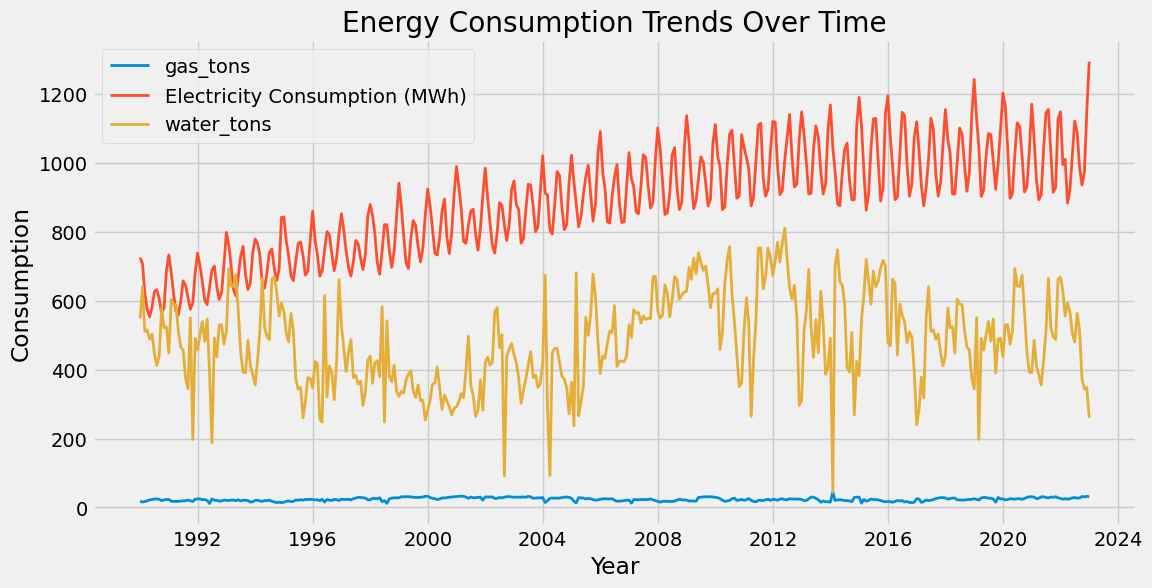

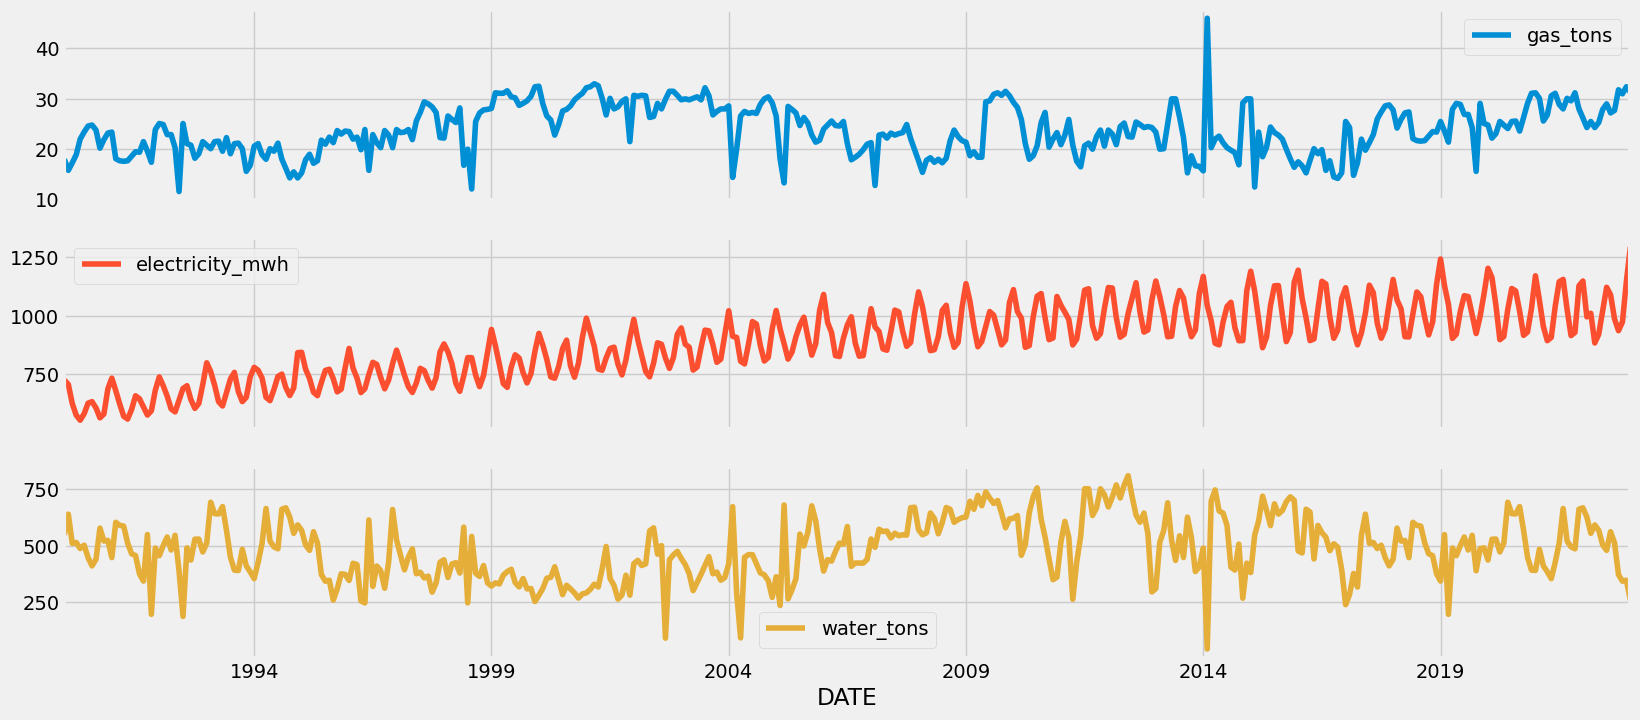

In [398]:
plt.figure(figsize=(12, 6))

# plot each energy type
plt.plot(df.index, df['gas_tons'], label='gas_tons', linewidth=2)
plt.plot(df.index, df['electricity_mwh'], label='Electricity Consumption (MWh)', linewidth=2)
plt.plot(df.index, df['water_tons'], label='water_tons', linewidth=2)

# style
plt.xlabel("Year")
plt.ylabel("Consumption")
plt.title("Energy Consumption Trends Over Time")
plt.grid(True)
plt.legend()
plt.show()

# plotting each on its own
df.plot(subplots=True, figsize=(18, 8))
plt.show()

### Stationarity Analysis
ARIMA expects stationary data (constant mean, variance and autocorrelation over time). This stability makes the data predictable, as its behavior is not dependent on the observation time.

In [399]:
rolling_window = 12 # months
consumption_types = [
  'electricity_mwh',
  'water_tons',
  'gas_tons'
]

cons_pal = {
  'electricity_mwh': "#FFA500",
  'water_tons': "#1E90FF",
  'gas_tons': "#1B7E1B"
}

##### Simple Moving Average
Check trend, seasonality and constant variance across the 3 energy types.

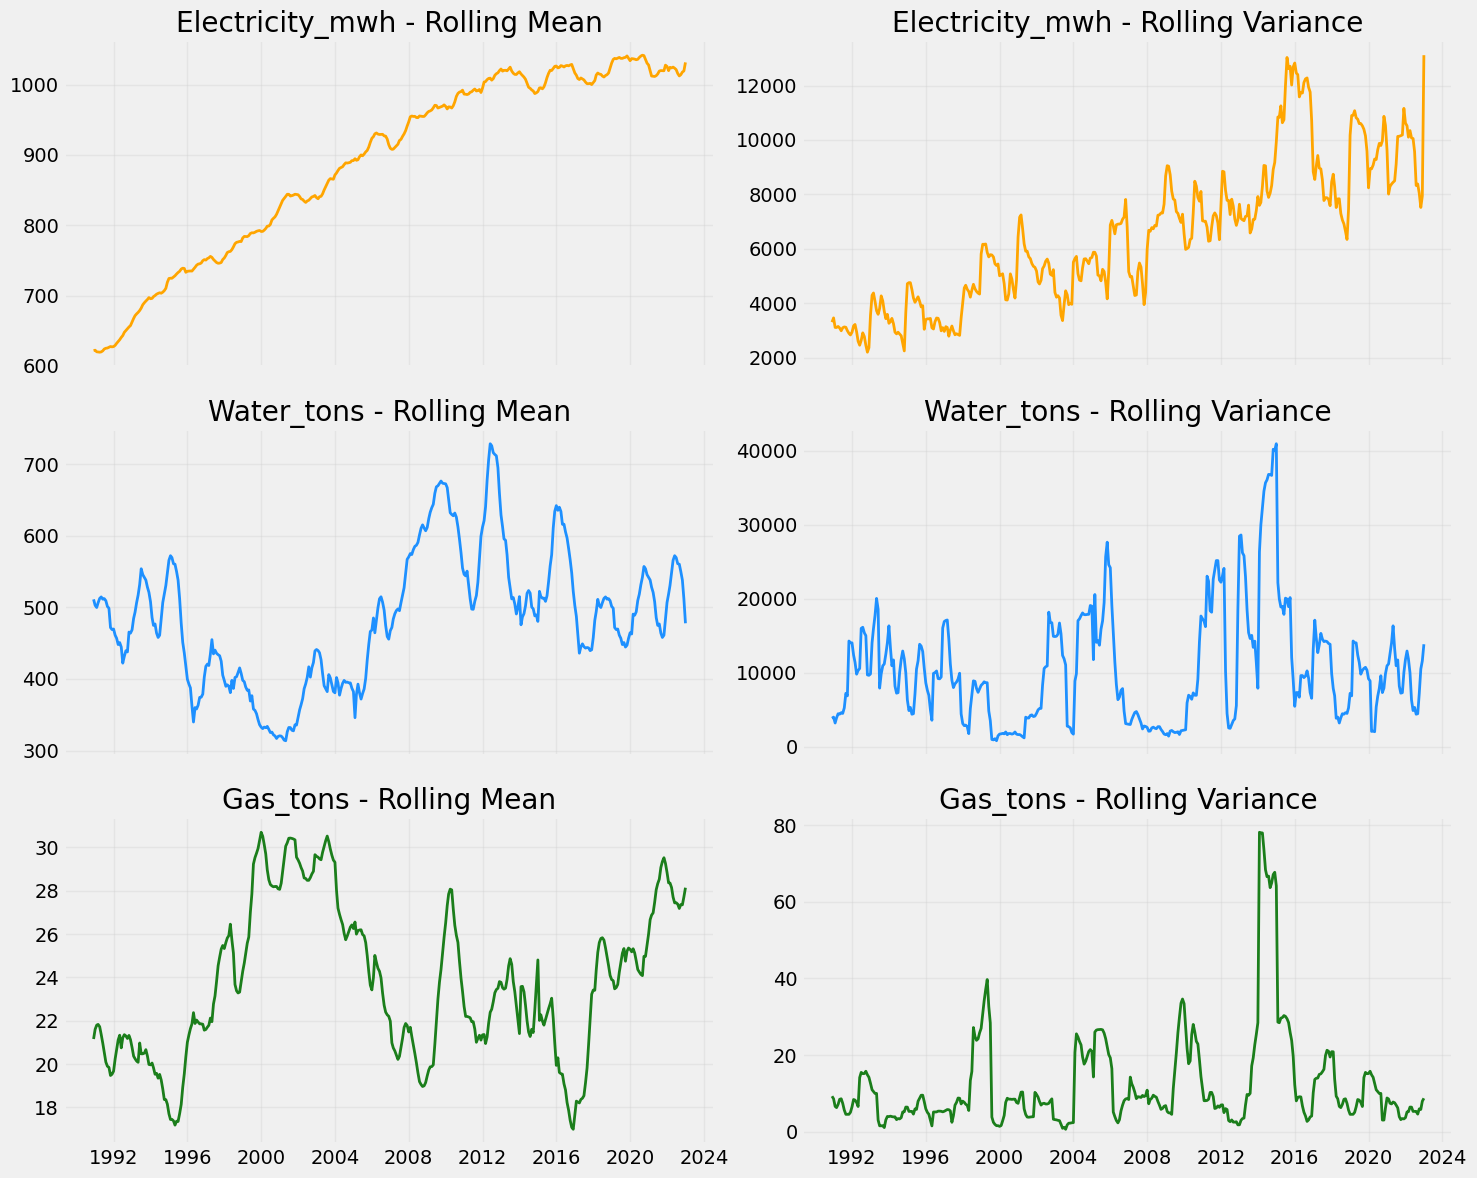

In [400]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharex=True)

for i, col in enumerate(consumption_types):
  rolling_mean = df[col].rolling(rolling_window).mean()
  rolling_var = df[col].rolling(rolling_window).var()

  # plot rolling mean
  axes[i, 0].plot(df.index, rolling_mean, linewidth=2, color=cons_pal[col])
  axes[i, 0].set_title(f"{col.capitalize()} - Rolling Mean")

  # plot rolling variance
  axes[i, 1].plot(df.index, rolling_var, linewidth=2, color=cons_pal[col])
  axes[i, 1].set_title(f"{col.capitalize()} - Rolling Variance")

for ax in axes.flatten():
  ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Electricity Consumption**
- Rolling mean shows strong upward trend, followed by a period of slower, more erratic growth around 2014 → suggests long-term non-stationarity in the mean.
- Rolling variance increases steadily over time → suggests **heteroskedasticity** (variability grows with consumption level).

**Water Consumption**
- Rolling mean does not show a consistent long-term trend. Displays multiple periods of rising and falling demand.
- Rolling variance has lots of large spikes, indicating strong non-stationarity in variance, likely driven by external factors like policies.

**Gas Consumption**
Displays moderate changes in the 
- Rolling mean shows moderate changes, characterised by regime shifts rather than a persistent trend. While its rolling variance is generally low, isolated volatility spikes indicate episodic shocks rather than sustained variance growth.

Across all three series, no clear seasonality is visible at the rolling-mean level; however, this may be partially due to the smoothing effect of the 12-month window, which suppresses seasonal fluctuations.

Overall, the SMA analysis suggests that all series are non-stationary in mean, while electricity and water also exhibit clear variance instability. Formal stationarity tests (ADF/KPSS) are therefore required to validate these visual findings. Variance-stabilising transformations such as Box-Cox are particularly appropriate for electricity and water consumption, while gas consumption may require only mild transformation or robust modelling approaches.

#### ADF (Augmented Dickey-Fuller) Test


In [401]:
def adf_test(series, name=""):
  result = adfuller(series.dropna())

  print(f"ADF Test for {name}")
  print(f"Test Statistic: {result[0]:.4f}")
  print(f"p-value: {result[1]:.4f}")
  print("Critical Values:")

  for key, value in result[4].items():
    print(f"   {key}: {value:.4f}")

  if result[1] < 0.05:
    print("Conclusion: Reject H0 → Series is stationary")
  else:
    print("Conclusion: Fail to reject H0 → Series is non-stationary")

  print("\n")

adf_test(df['electricity_mwh'], "Electricity Consumption")
adf_test(df['water_tons'], "Water Consumption")
adf_test(df['gas_tons'], "Gas Consumption")

ADF Test for Electricity Consumption
Test Statistic: -2.2570
p-value: 0.1862
Critical Values:
   1%: -3.4476
   5%: -2.8692
   10%: -2.5708
Conclusion: Fail to reject H0 → Series is non-stationary


ADF Test for Water Consumption
Test Statistic: -4.6848
p-value: 0.0001
Critical Values:
   1%: -3.4471
   5%: -2.8689
   10%: -2.5707
Conclusion: Reject H0 → Series is stationary


ADF Test for Gas Consumption
Test Statistic: -3.4044
p-value: 0.0108
Critical Values:
   1%: -3.4472
   5%: -2.8690
   10%: -2.5707
Conclusion: Reject H0 → Series is stationary




#### KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test

In [402]:
def kpss_test(series, name="", regression="c"):
  statistic, p_value, lags, critical_values = kpss(
    series.dropna(),
    regression=regression,
    nlags="auto"
  )

  print(f"KPSS Test for {name}")
  print(f"Test Statistic: {statistic:.4f}")
  print(f"p-value: {p_value:.4f}")
  print("Critical Values:")

  for key, value in critical_values.items():
    print(f"   {key}: {value}")

  if p_value < 0.05:
    print("Conclusion: Reject H0 → Series is non-stationary")
  else:
    print("Conclusion: Fail to reject H0 → Series is stationary")
  print("\n")

kpss_test(df['electricity_mwh'], "Electricity Consumption")
kpss_test(df['water_tons'], "Water Consumption")
kpss_test(df['gas_tons'], "Gas Consumption")

KPSS Test for Electricity Consumption
Test Statistic: 3.5316
p-value: 0.0100
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Conclusion: Reject H0 → Series is non-stationary


KPSS Test for Water Consumption
Test Statistic: 0.8388
p-value: 0.0100
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Conclusion: Reject H0 → Series is non-stationary


KPSS Test for Gas Consumption
Test Statistic: 0.3402
p-value: 0.1000
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Conclusion: Fail to reject H0 → Series is stationary




C:\Users\lokej\AppData\Local\Temp\ipykernel_52524\1236932188.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, lags, critical_values = kpss(
C:\Users\lokej\AppData\Local\Temp\ipykernel_52524\1236932188.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, lags, critical_values = kpss(
C:\Users\lokej\AppData\Local\Temp\ipykernel_52524\1236932188.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, lags, critical_values = kpss(


#### Interpret ADF & KPSS Results
![How to interpret ADF and KPSS](interpret_ADF_KPSS.png)  


**Summary of Results**
| Energy Type | ADF p-value | ADF Conclusion | KPSS p-value | KPSS Conclusion | Overall Stationarity |
|-----------|------------|---------------|-------------|----------------|---------------------|
| Electricity | 0.1862 | Non-stationary | 0.0100 | Non-stationary | **Non-stationary** |
| Water | 0.0001 | Stationary | 0.0100 | Non-stationary | **Inconclusive (trend-stationary)** |
| Gas | 0.0108 | Stationary | 0.1000 | Stationary | **Stationary** |

Electricity
- Both ADF and KPSS tests indicate changing mean over time. Differencing required.

Water
- ADF suggests stationarity, while KPSS rejects it, indicating trend-stationarity. Differencing or detrending required.

Gas
- Both ADF and KPSS tests suggest stationarity. Differencing not required.

_Note: The KPSS interpolation warnings indicate very strong evidence for the conclusions and do not invalidate the results._

---

## **STAGE 2: Preprocessing & Feature Engineering**

### Box-Cox transform
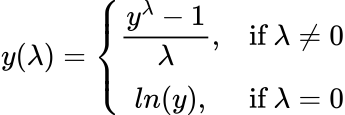

Lambda value is estimated by maximising the likelihood of the transformed original series. It tells us what power should be applied to the raw data distribution.

Box–Cox reshapes the data distribution to make it:
- more symmetric
- less right-skewed
- more constant in variance over time

#### Calculate λ
Decide if Box-Cox is necessary for each feature.

In [403]:
ys_bc = {}
lambdas_bc = {}

for type in consumption_types:
  y = df[type]
  y_bc, lambda_bc = boxcox(y)
  ys_bc[type] = y_bc
  lambdas_bc[type] = lambda_bc

lambdas_bc

{'electricity_mwh': np.float64(1.074887946525938),
 'water_tons': np.float64(1.0426534628565798),
 'gas_tons': np.float64(0.7801344320906498)}

- Water and Electricity consumption do not require boxcox as their lambda values (~1.04 & ~1.07 respectively) are very near 1. Applying the transformation would effect minimal changes to the data.

- Gas consumption shows mild right skew, Box–Cox can gently compress the data.

- **NOTE:** After performing first-order differencing on Electricity consumption, I noticed that the differenced series' rolling variance still shows a mild upward trend (not constant). Thus, I backtracked and applied box-cox to it too.

#### Box_Cox `electricity_mwh` and `gas_tons`

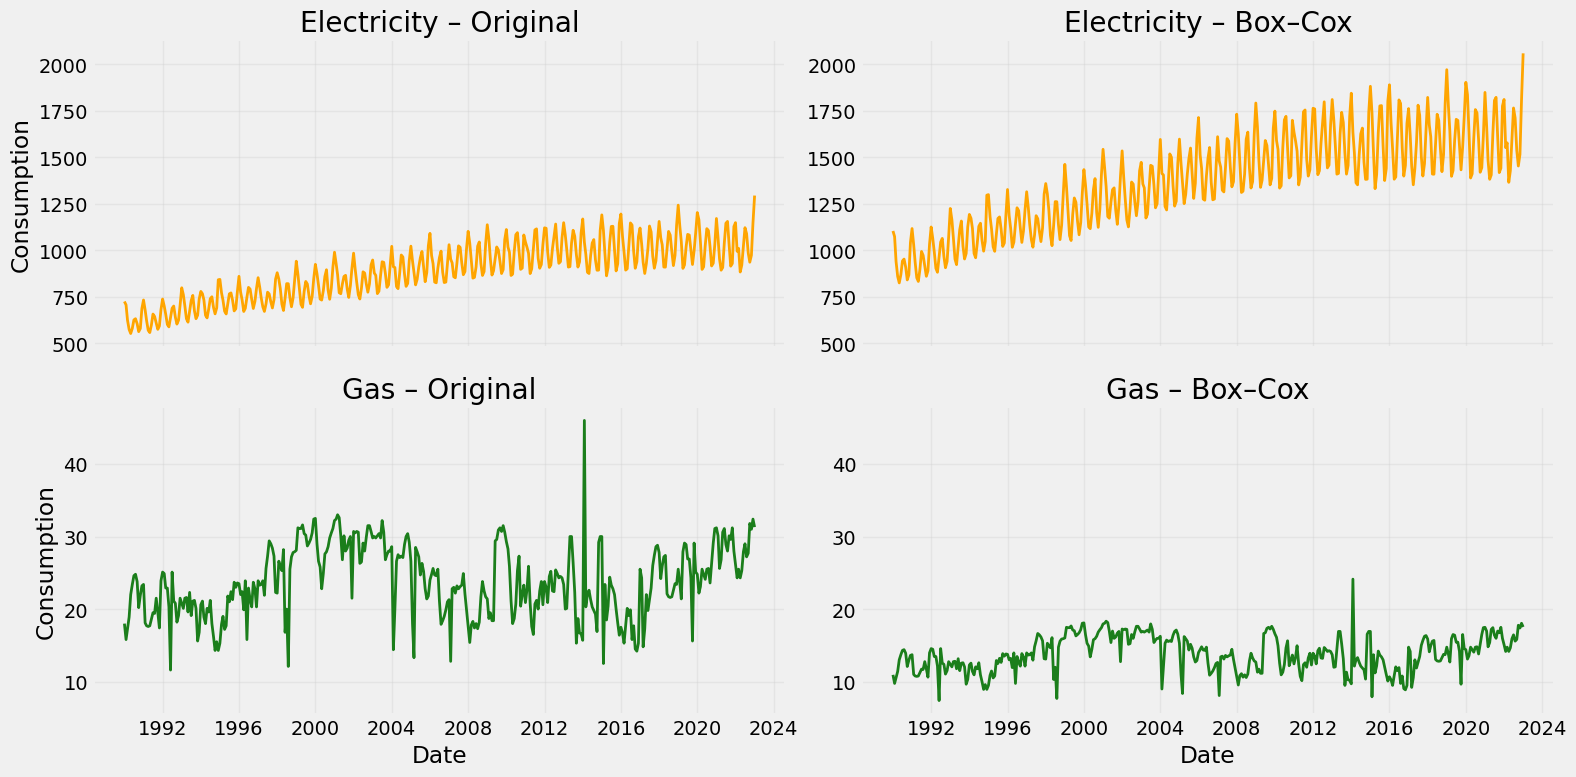

In [404]:
# Apply Box-Cox transform
df["gas_tons_bc"] = ys_bc["gas_tons"]
df["electricity_mwh_bc"] = ys_bc["electricity_mwh"]

fig, ax = plt.subplots(2, 2, figsize=(16, 8), sharex=True)

# 1. Electricity Consumption
# Original
ax[0, 0].plot(df.index, df["electricity_mwh"],
              linewidth=2, color=cons_pal["electricity_mwh"])
ax[0, 0].set_title("Electricity – Original")
ax[0, 0].set_ylabel("Consumption")
ax[0, 0].grid(True, alpha=0.3)

# Box–Cox
ax[0, 1].plot(df.index, df["electricity_mwh_bc"],
              linewidth=2, color=cons_pal["electricity_mwh"])
ax[0, 1].set_title("Electricity – Box–Cox")
ax[0, 1].grid(True, alpha=0.3)
ax[0, 1].sharey(ax[0, 0])

# 2. Gas Consumption
# Original
ax[1, 0].plot(df.index, df["gas_tons"],
              linewidth=2, color=cons_pal["gas_tons"])
ax[1, 0].set_title("Gas – Original")
ax[1, 0].set_ylabel("Consumption")
ax[1, 0].set_xlabel("Date")
ax[1, 0].grid(True, alpha=0.3)

# Box–Cox
ax[1, 1].plot(df.index, df["gas_tons_bc"],
              linewidth=2, color=cons_pal["gas_tons"])
ax[1, 1].set_title("Gas – Box–Cox")
ax[1, 1].set_xlabel("Date")
ax[1, 1].grid(True, alpha=0.3)
ax[1, 1].sharey(ax[1, 0])

plt.tight_layout()
plt.show()

Effects of the Box-Cox Transformation:
- **Electricity Consumption**: Extrapolated values to stabilise variance 
- **Gas Consumption**: Compressed high gas consumption values, reduced right skewness and stabilised variance, giving a smoother and more model-ready time series.

### First-Order Differencing: `electricity_mwh`

In [405]:
def plot_series(
  series,
  title,
  ax,
  rolling_window=None,
  diff=False,
  color='blue',
  ylabel=None
):
  ax.plot(
    series,
    color=color,
    label='1st Difference' if diff else 'Original',
    linewidth=2
  )

  if rolling_window:
    ax.plot(
      series.rolling(rolling_window).mean(),
      'r--',
      label='Rolling Mean'
    )
    ax.plot(
      series.rolling(rolling_window).std(),
      'k--',
      label='Rolling Std'
    )

  ax.set_title(title)
  ax.set_xlabel('Date')

  if ylabel: ax.set_ylabel(ylabel)
  else: ax.set_ylabel('Value' + (' (Diff)' if diff else ''))
  ax.legend()

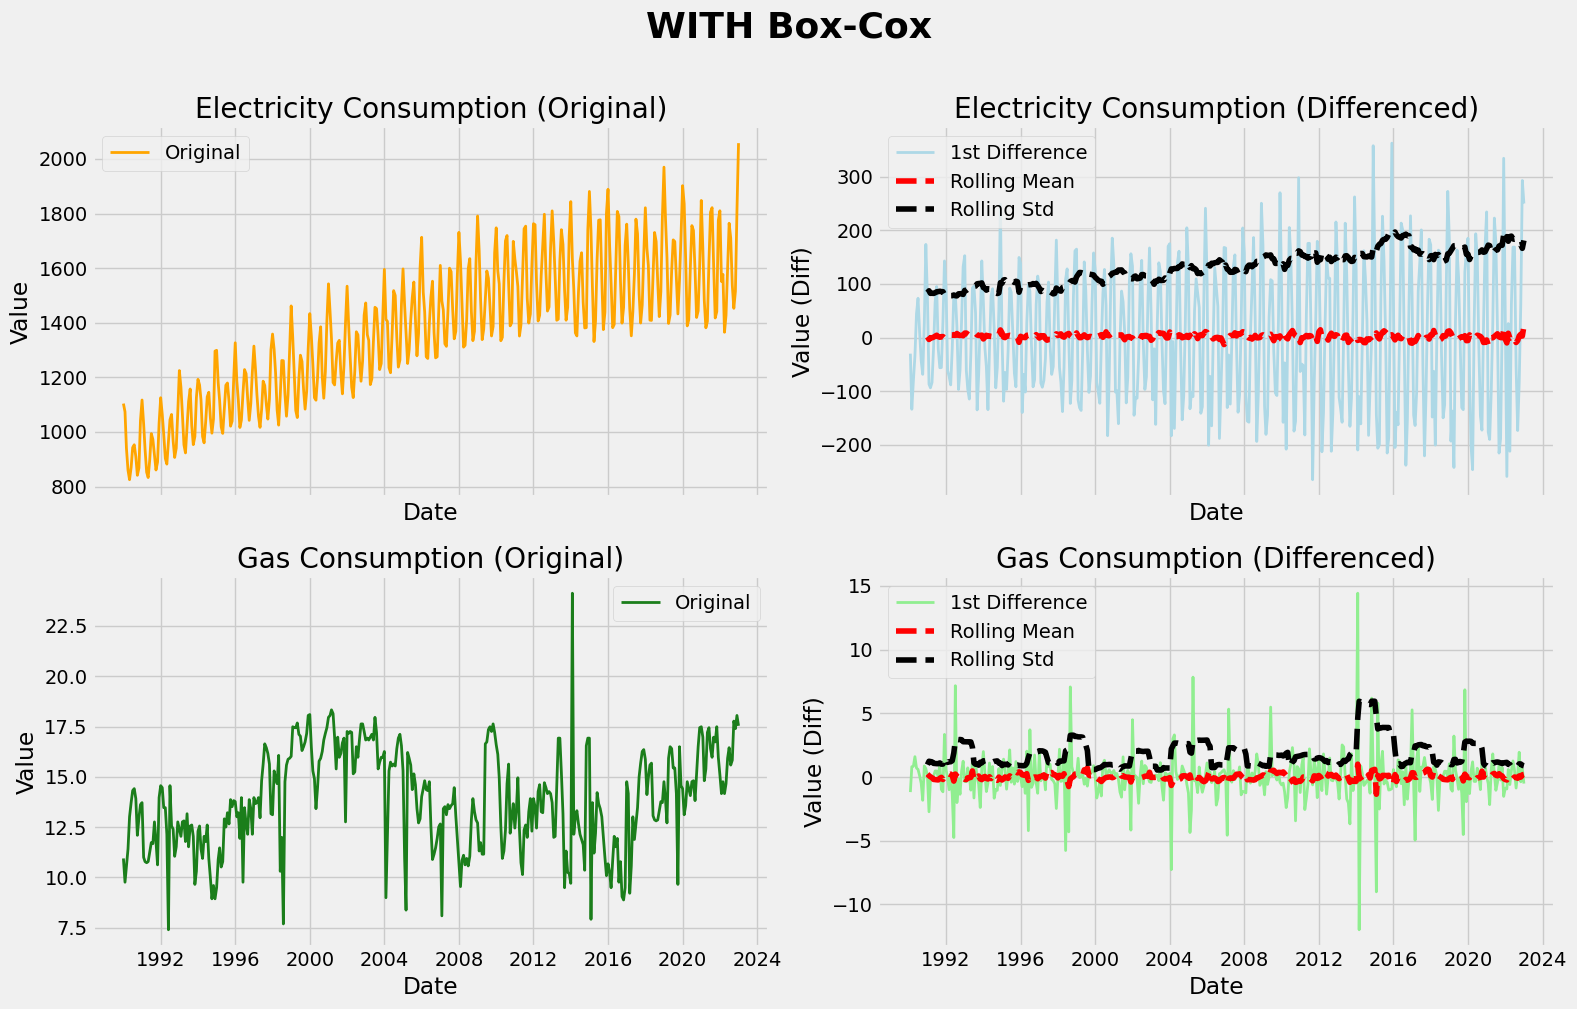

In [406]:
# first-order differencing after Box–Cox
df['electricity_bc_diff1'] = df['electricity_mwh_bc'].diff()
df['gas_bc_diff1'] = df['gas_tons_bc'].diff()

fig, ax = plt.subplots(2, 2, figsize=(16, 10), sharex=True)

# 1. Electricity
plot_series(
  df['electricity_mwh_bc'],
  title='Electricity Consumption (Original)',
  ax=ax[0, 0],
  color=cons_pal["electricity_mwh"]
)

plot_series(
  df['electricity_bc_diff1'],
  title='Electricity Consumption (Differenced)',
  ax=ax[0, 1],
  rolling_window=rolling_window,
  diff=True,
  color='lightblue'
)

# 2. Gas
plot_series(
  df['gas_tons_bc'],
  title='Gas Consumption (Original)',
  ax=ax[1, 0],
  color=cons_pal["gas_tons"]
)

plot_series(
  df['gas_bc_diff1'],
  title='Gas Consumption (Differenced)',
  ax=ax[1, 1],
  rolling_window=rolling_window,
  diff=True,
  color='lightgreen'
)

plt.suptitle("WITH Box-Cox", fontsize=26, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

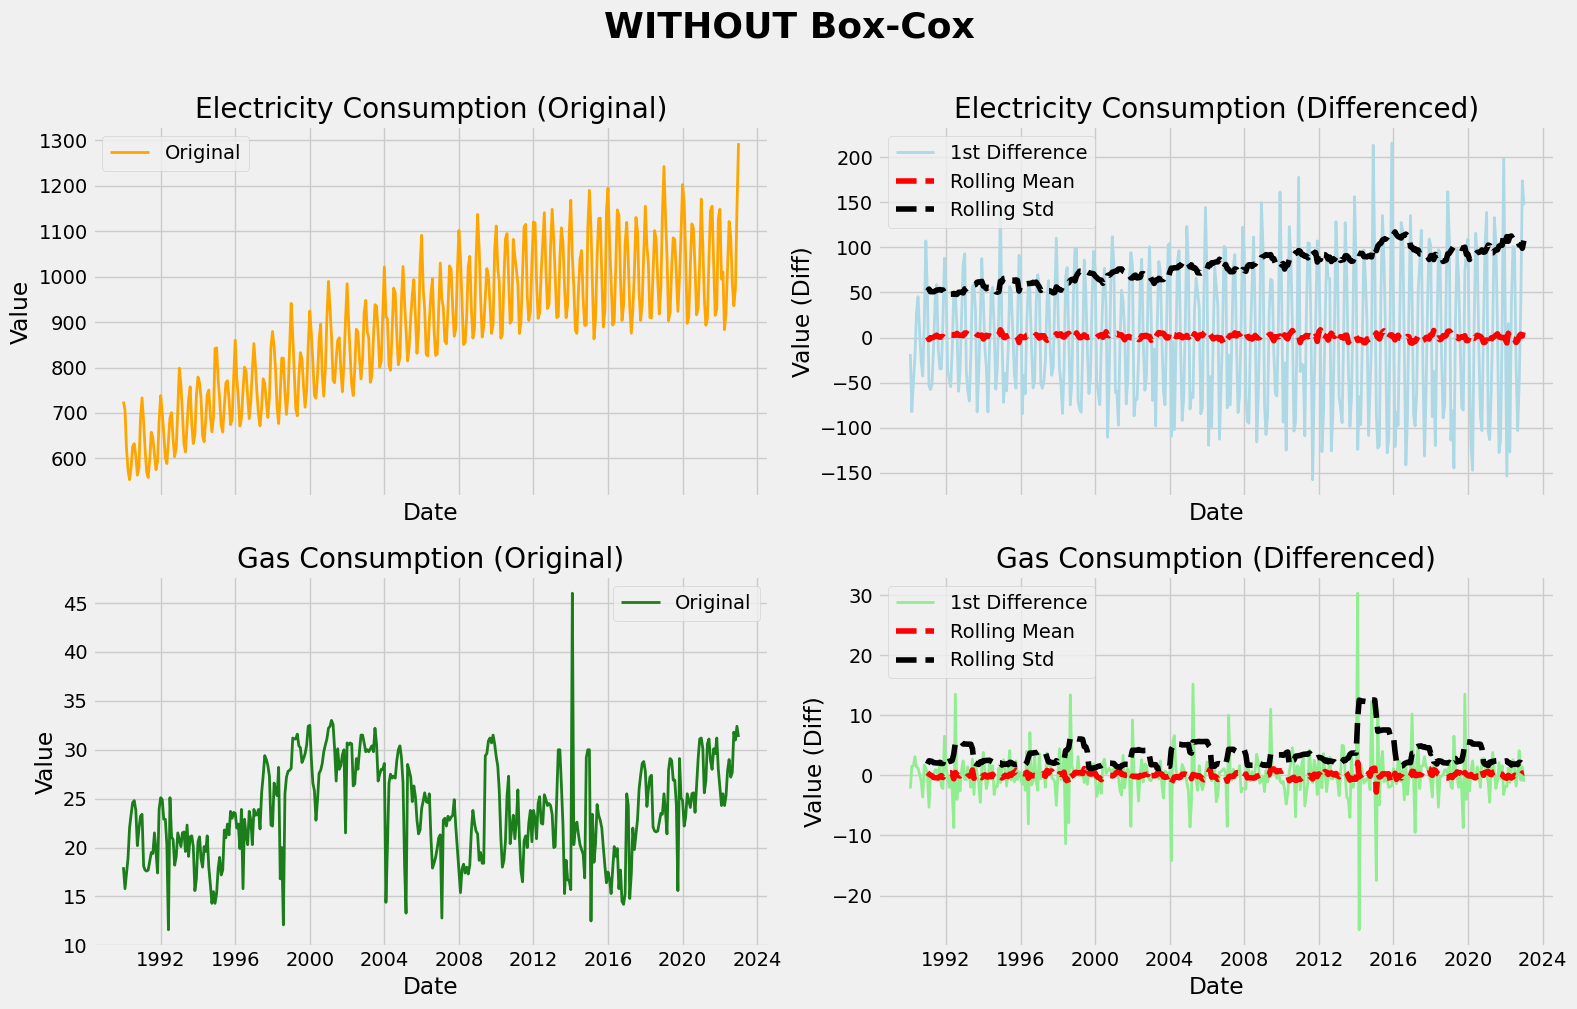

In [407]:
# first-order differencing before Box–Cox
df['electricity_noBc_diff1'] = df['electricity_mwh'].diff()
df['gas_noBc_diff1'] = df['gas_tons'].diff()

fig, ax = plt.subplots(2, 2, figsize=(16, 10), sharex=True)

# 1. Electricity
plot_series(
  df['electricity_mwh'],
  title='Electricity Consumption (Original)',
  ax=ax[0, 0],
  color=cons_pal["electricity_mwh"]
)

plot_series(
  df['electricity_noBc_diff1'],
  title='Electricity Consumption (Differenced)',
  ax=ax[0, 1],
  rolling_window=rolling_window,
  diff=True,
  color='lightblue'
)

# 2. Gas
plot_series(
  df['gas_tons'],
  title='Gas Consumption (Original)',
  ax=ax[1, 0],
  color=cons_pal["gas_tons"]
)

plot_series(
  df['gas_noBc_diff1'],
  title='Gas Consumption (Differenced)',
  ax=ax[1, 1],
  rolling_window=rolling_window,
  diff=True,
  color='lightgreen'
)

plt.suptitle("WITHOUT Box-Cox", fontsize=26, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

- Electricity Consumption is stationary after differencing once, as seen from the constant mean. 

- Box-Cox transformation does not seem to help, both differenced plots look nearly identical but with different scales.

- Heteroscedasticity observed: variance not constant.The "sin wave" shape in the rolling std is showing:
  - Increasing trend (variance growing over time)
  - Seasonal volatility patterns (regular fluctuations)

### Try Log-Transform
Fix Heteroscedasticity (the variance of error terms/residuals is not constant across all levels of an independent variable)

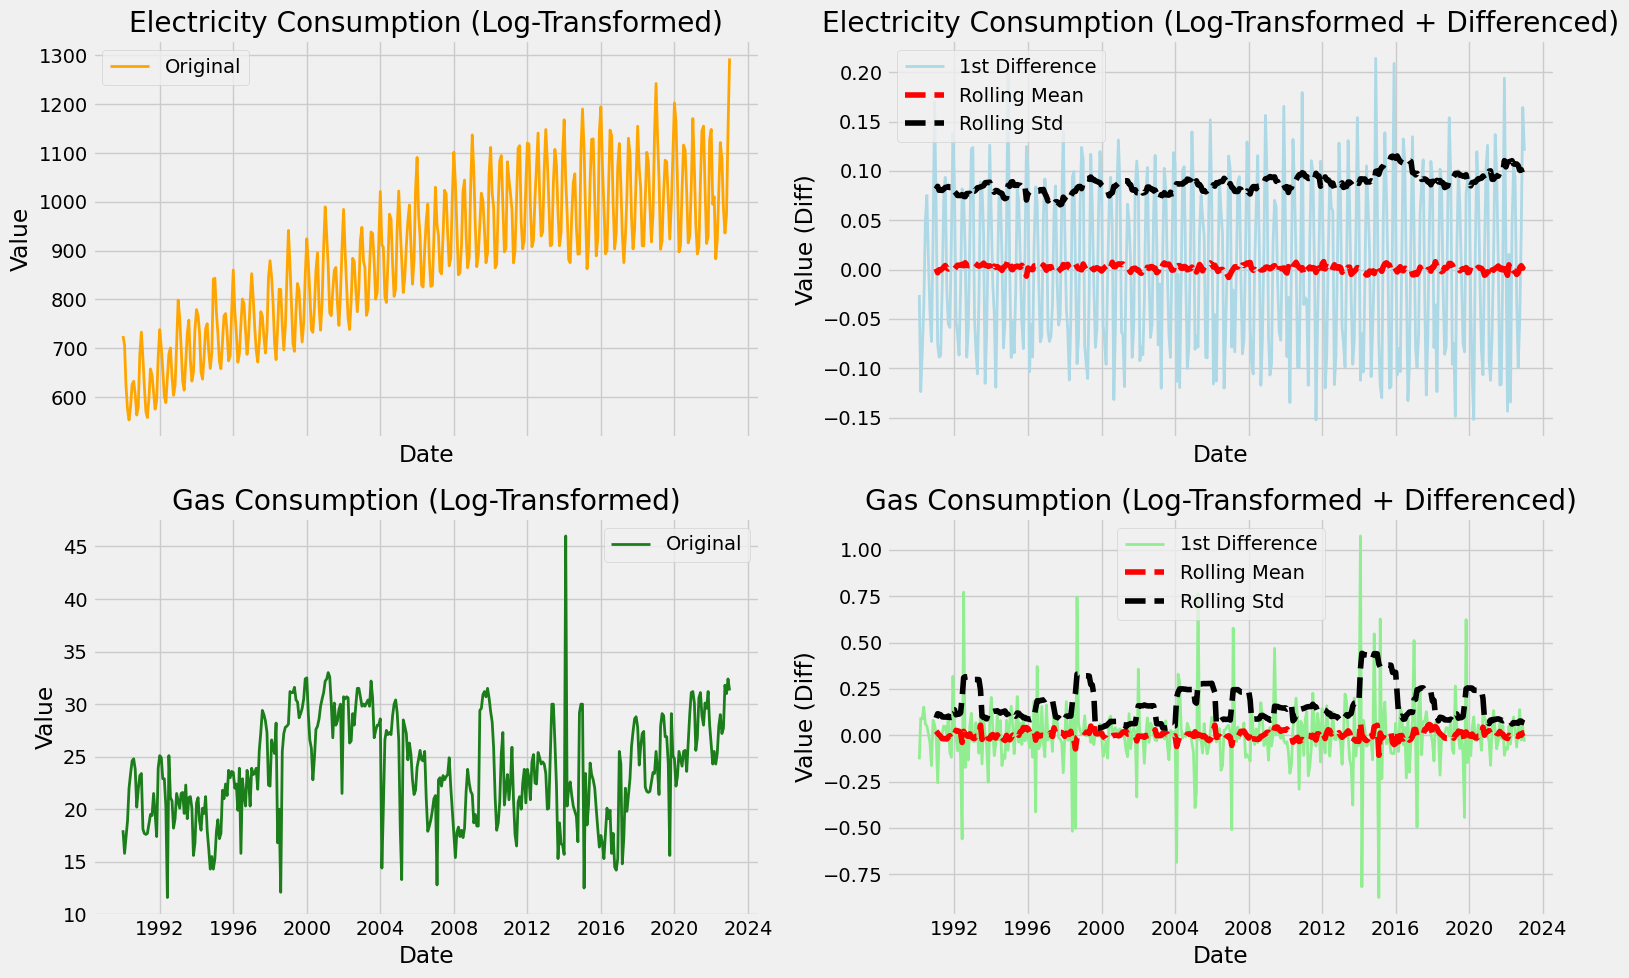

ADF Test for Log-Transformed Electricity Consumption
Test Statistic: -6.7482
p-value: 0.0000
Critical Values:
   1%: -3.4476
   5%: -2.8692
   10%: -2.5708
Conclusion: Reject H0 → Series is stationary


ADF Test for Log-Transformed Gas Consumption
Test Statistic: -7.7382
p-value: 0.0000
Critical Values:
   1%: -3.4477
   5%: -2.8692
   10%: -2.5708
Conclusion: Reject H0 → Series is stationary




In [408]:
# first-order differencing after Log-Transform
df["electricity_mwh_log"] = np.log(df["electricity_mwh"])
df["electricity_log_diff1"] = df["electricity_mwh_log"].diff().dropna()
df["gas_tons_log"] = np.log(df["gas_tons"])
df["gas_log_diff1"] = df["gas_tons_log"].diff().dropna()

fig, ax = plt.subplots(2, 2, figsize=(16, 10), sharex=True)

# 1. Electricity
plot_series(
  df['electricity_mwh'],
  title='Electricity Consumption (Log-Transformed)',
  ax=ax[0, 0],
  color=cons_pal["electricity_mwh"]
)

plot_series(
  df['electricity_log_diff1'],
  title='Electricity Consumption (Log-Transformed + Differenced)',
  ax=ax[0, 1],
  rolling_window=rolling_window,
  diff=True,
  color='lightblue'
)

# 2. Gas
plot_series(
  df['gas_tons'],
  title='Gas Consumption (Log-Transformed)',
  ax=ax[1, 0],
  color=cons_pal["gas_tons"]
)

plot_series(
  df['gas_log_diff1'],
  title='Gas Consumption (Log-Transformed + Differenced)',
  ax=ax[1, 1],
  rolling_window=rolling_window,
  diff=True,
  color='lightgreen'
)

plt.tight_layout()
plt.show()

adf_test(df["electricity_log_diff1"], "Log-Transformed Electricity Consumption")
adf_test(df["gas_log_diff1"], "Log-Transformed Gas Consumption")

##### **Electricity Consumption**
- Rolling std more stable (~0.08-0.10 range)
- Rolling mean centered around 0 (good for differenced data)
- Looks acceptable for ARIMA, showed better results for variance than Box-Cox and Scaling

***Conclusion: go with Log-Transformed electricity consumption data***

##### **Gas Consumption**
- xx

***Conclusion: go with xxx gas consumption data***

In [409]:
# clean up other test columns
print("BEFORE clean-up:\n", df.columns)
df.drop(columns=[
  "electricity_mwh_bc",
  "electricity_bc_diff1",
  "electricity_noBc_diff1",
  "gas_tons_log",
  "gas_log_diff1"], 
  inplace=True)
print("\nAFTER clean-up:", df.columns)

BEFORE clean-up:
 Index(['gas_tons', 'electricity_mwh', 'water_tons', 'gas_tons_bc',
       'electricity_mwh_bc', 'electricity_bc_diff1', 'gas_bc_diff1',
       'electricity_noBc_diff1', 'gas_noBc_diff1', 'electricity_mwh_log',
       'electricity_log_diff1', 'gas_tons_log', 'gas_log_diff1'],
      dtype='object')

AFTER clean-up: Index(['gas_tons', 'electricity_mwh', 'water_tons', 'gas_tons_bc',
       'gas_bc_diff1', 'gas_noBc_diff1', 'electricity_mwh_log',
       'electricity_log_diff1'],
      dtype='object')


### Autocorrelation Analysis
Use differenced data to check data is independent.

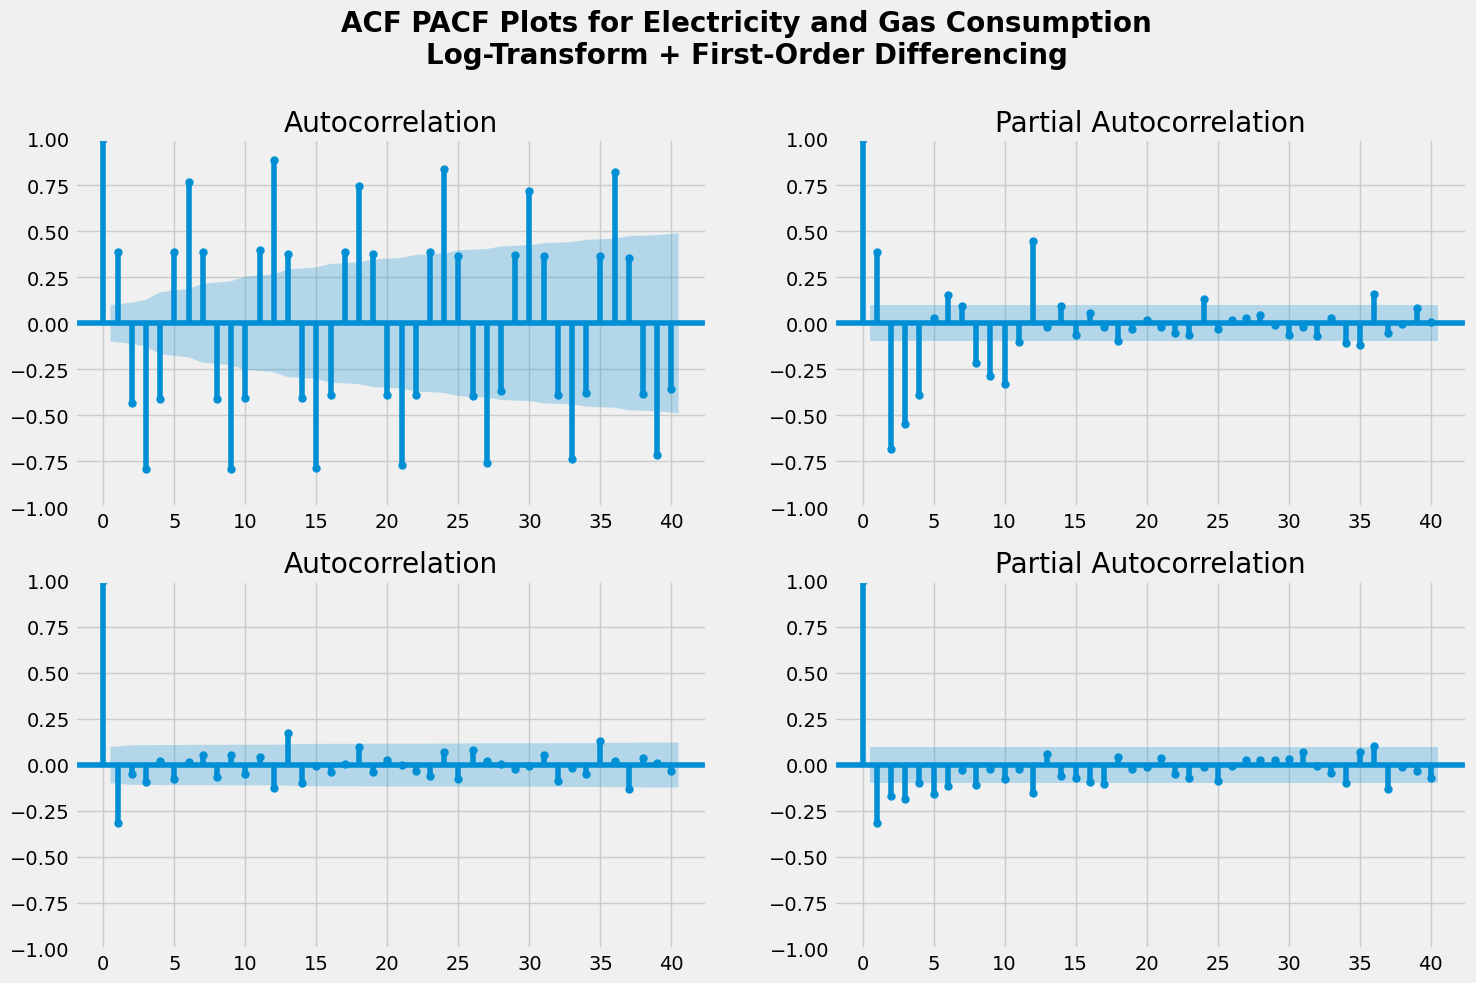

In [410]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10))
plot_acf(df['electricity_log_diff1'].dropna(), lags=40, ax=ax[0, 0])
plot_pacf(df['electricity_log_diff1'].dropna(), lags=40, ax=ax[0, 1])
plot_acf(df['gas_bc_diff1'].dropna(), lags=40, ax=ax[1, 0])
plot_pacf(df['gas_bc_diff1'].dropna(), lags=40, ax=ax[1, 1])
plt.suptitle("ACF PACF Plots for Electricity and Gas Consumption\nLog-Transform + First-Order Differencing", fontsize=20, fontweight="bold", y=1.01)
plt.show()

##### **ACF**

**Electricity Consumption**  

🔹 Spikes @ Lag 1–2
  - Significant spikes → short-term dependence
  - Suggests MA or AR terms

🔹 BIG Spikes @ Lag 12, 24, 36
  - Strong 12-month/annual seasonality
  - Confirms seasonal period = 12
  - SARIMA will work better than ARIMA
 
🔹 Slow decay instead of sharp cut-off
  - Spikes are not of equal height, exhibits decreasing trend. Expected for our energy consumption data.

**Gas Consumption**  

🔹

##### **PACF**

**Electricity Consumption**  

🔹 Lag 1–2
  - Significant → AR(1) or AR(2) likely

🔹 Seasonal Spike @ Lag 12
  - Suggests seasonal AR(1)

🔹 After Lag ~15
  - Mostly noise, this is good as model order won’t be huge

**Gas Consumption**  

🔹

##### **Conclusion**

**Electricity**  
  - Non-seasonal MA component exists
  - Strong seasonal component exists  
  - Seasonal differencing or seasonal AR/MA needed
  - Small p, Seasonal P = 1

### Seasonal Differencing
Our final preprocessing step after inspecting the ACF and PACF plots. They showed a strong seasonality of 12months, which is expected in our energy consumption data.

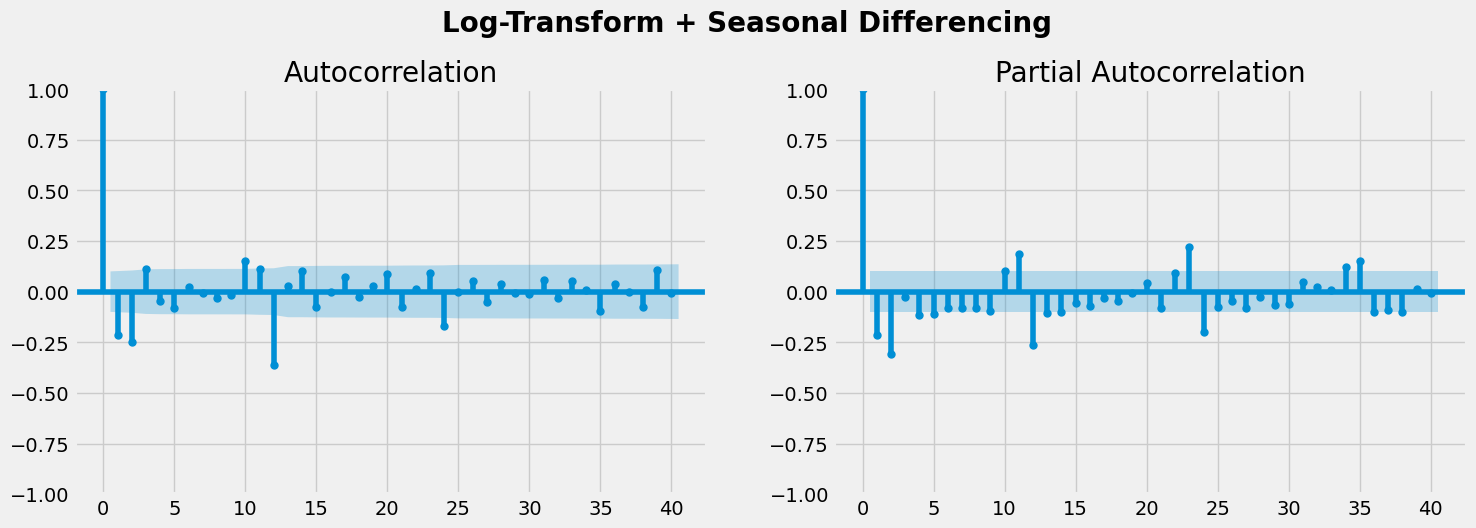

In [411]:
df["electricity_log_diff1_seasonal"] = df["electricity_log_diff1"].diff(12).dropna()
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(df['electricity_log_diff1_seasonal'].dropna(), lags=40, ax=ax[0])
plot_pacf(df['electricity_log_diff1_seasonal'].dropna(), lags=40, ax=ax[1])
plt.suptitle("Log-Transform + Seasonal Differencing", fontsize=20, fontweight="bold", y=1.04)
plt.show()

- Seasonal Differencing successfully removed most of the seasonality in our electricity consumption data.

---

### **Auto-ARIMA**
Why Auto-ARIMA? It provides a quick and easy way to sanity-check my interpretations and findings above. **Auto ARIMA will NOT be used for my final model fitting**.  
Find the ARIMA with the lowest AIC (Akaike Information Criterion): “How good is the fit while penalising complexity?”  
AIC was only compared within the same dataset to ensure results are valid.

In [412]:
# model = auto_arima(
#   df['electricity_mwh_log'].dropna(), 
#   seasonal=True, m=12, # monthly seasonality
#   trace=True
# )

To prevent long runtimes, I have screenshotted the results below:  
![Auto-ARIMA output](auto-ARIMA-results.png)  

**Auto-ARIMA found:**
```
Best model:  ARIMA(2,1,5)(1,0,2)[12]          
Total fit time: 131.152 seconds
```

➙ p = 2  
➙ d = 1 (ignore, as I already have a differenced electricity column in my df)  
➙ q = 5  
➙ Seasonal AR(1), MA(2), ___no seasonal differencing___, season length of 12  

Most of Auto-ARIMA's results align with ours, except the lack of seasonal differencing is strange. We will try comparing ARIMA and SARIMA in the subsequent Modelling section.

### Train Test Split
The dataset was split chronologically into training and testing sets to prevent data leakage and reflect real-world forecasting conditions.

In [413]:
# tscv = TimeSeriesSplit(n_splits=5)

# for train_idx, val_idx in tscv.split(df):
#   train, val = df.iloc[train_idx], df.iloc[val_idx]

train_electricity = df.loc[:'2018-12-01', 'electricity_mwh_log']
test_electricity  = df.loc['2019-01-01':, 'electricity_mwh_log']
train_water = df.loc[:'2018-12-01', 'water_tons']
test_water  = df.loc['2019-01-01':, 'water_tons']
train_gas = df.loc[:'2018-12-01', 'gas_tons_bc']
test_gas  = df.loc['2019-01-01':, 'gas_tons_bc']

---

## **STAGE 3: Modelling & Evaluation**

Evaluating SARIMA Parameters
- **P > |z|** → Significant if < 0.05, else candidate for removal
- **|z| ≥ 2** → Significant
- Check if 0 lies inside the 95% confidence interval → Significant if not inside

---

### **Electricity Consumption (kWh)**

#### Experiment Best SARIMA

In [414]:
models = {
  'SARIMA_215_102': (2, 1, 5, 1, 0, 2, 12),  # Suggested by Auto ARIMA
  'SARIMA_111_111': (1, 1, 1, 1, 1, 1, 12),  # Add seasonal MA
  'SARIMA_011_011': (0, 1, 1, 0, 1, 1, 12),  # Pure MA approach
  'SARIMA_110_111': (1, 1, 0, 1, 1, 1, 12),  # No non-seasonal MA
  'SARIMA_211_111': (2, 1, 1, 1, 1, 1, 12),  # More AR terms
  'SARIMA_112_111': (1, 1, 2, 1, 1, 1, 12)   # More MA terms
}

results = []

for name, (p, d, q, P, D, Q, s) in models.items():
  # fit model
  model = SARIMAX(
    train_electricity,
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
  )

  fitted = model.fit(disp=False)

  # calculate evaluation metrics
  forecast = fitted.get_forecast(steps=len(test_electricity))
  y_pred = forecast.predicted_mean
  rmse = np.sqrt(mean_squared_error(test_electricity, y_pred))
  mae = mean_absolute_error(test_electricity, y_pred)

  results.append({
    'Model': name,
    'Order': f'({p},{d},{q})({P},{D},{Q},{s})',
    'AIC': fitted.aic,
    'BIC': fitted.bic,
    'RMSE': rmse,
    'MAE': mae
  })

results_df = pd.DataFrame(results)
results_df.sort_values(['RMSE', 'AIC'])

C:\Users\lokej\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\lokej\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Model,Order,AIC,BIC,RMSE,MAE
1,SARIMA_111_111,"(1,1,1)(1,1,1,12)",-1480.811284,-1461.954078,0.037501,0.029810
4,SARIMA_211_111,"(2,1,1)(1,1,1,12)",-1479.790111,-1457.161464,0.037649,0.029922
5,SARIMA_112_111,"(1,1,2)(1,1,1,12)",-1475.084643,-1452.474717,0.037665,0.029940
0,SARIMA_215_102,"(2,1,5)(1,0,2,12)",-1445.295901,-1403.947981,0.041734,0.033493
2,SARIMA_011_011,"(0,1,1)(0,1,1,12)",-1446.540398,-1435.226075,0.056683,0.049205
3,SARIMA_110_111,"(1,1,0)(1,1,1,12)",-1437.795844,-1422.697638,0.067028,0.058564


SARIMA_111_111 beats all the models in AIC, BIC, RMSE and MAE!

SARIMA parameters for Electricity Consumption:
- p = 1
- d = 1
- q = 1
- P = 1
- D = 1
- Q = 1

#### Fit Best SARIMA (111_111)

                                     SARIMAX Results                                      
Dep. Variable:                electricity_mwh_log   No. Observations:                  348
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 745.406
Date:                            Mon, 02 Feb 2026   AIC                          -1480.811
Time:                                    18:02:12   BIC                          -1461.954
Sample:                                01-01-1990   HQIC                         -1473.282
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5056      0.069      7.356      0.000       0.371       0.640
ma.L1         -0.9141      0.032   

,lb_stat,lb_pvalue
12,95.001541,5.274255e-15
24,101.067041,1.974857e-11


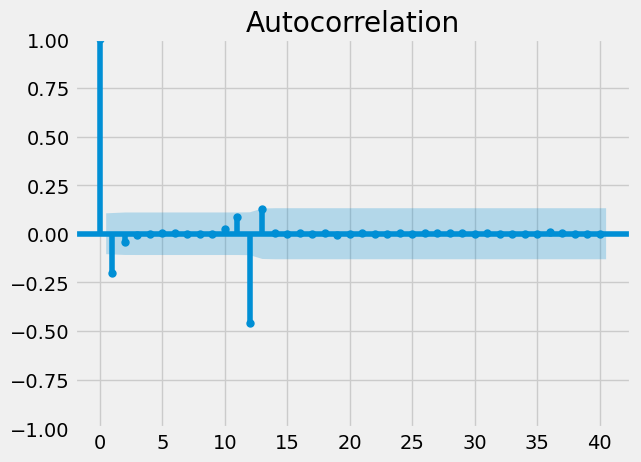

In [415]:
SARIMA_111_111 = SARIMAX(
  train_electricity,
  order=(1, 1, 1), # p, d, q
  seasonal_order=(1, 1, 1, 12), # P, D, Q, m
  enforce_stationarity=False,
  enforce_invertibility=False
)

fit_111_111 = SARIMA_111_111.fit()

print(fit_111_111.summary())
plot_acf(fit_111_111.resid.dropna(), lags=40) # plot residual ACF
acorr_ljungbox(fit_111_111.resid.dropna(), lags=[12, 24], return_df=True) # Ljung-Box test

**Interpreting the Results**

SARIMA Results Summary
Given our AIC is **below zero** (-1480),
- ar.S.L12 (Seasonal AR) has a coefficient of 0.187 → not significant
- ma.S.L12 (Seasonal MA) has a coefficient of -0.8207 → VERY significant

Residual ACF Plot
- Most lags close to zero
- Differencing proves to be effective as there are no slow decays and no obvious seasonal patterns (like in the ACF plot before applying seasonal differencing)
- Large negative spike at lag 12 suggests that there is **remaining seasonal autocorrelation at 12 months** that the model did not fully absorb. The model is **not fully specified**.

Ljung-Box test
- Lag 12 p-value way below 0.05
- Lag 24 p-value much closer but still way below 0.05

**Conclusion**
- Seasonal AR term is useless, seasonal MA term is carrying the seasonality portion of our best SARIMA model
- Residual ACF plot and Ljung-Box test results tell me for certain that **residuals are not white noise at seasonal horizons**

→ I will Remove Seasonal AR term and re-fit the model.

#### Fit Improved SARIMA (111_011)

                                     SARIMAX Results                                      
Dep. Variable:                electricity_mwh_log   No. Observations:                  348
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 745.205
Date:                            Mon, 02 Feb 2026   AIC                          -1482.409
Time:                                    18:02:13   BIC                          -1467.324
Sample:                                01-01-1990   HQIC                         -1476.386
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5123      0.066      7.728      0.000       0.382       0.642
ma.L1         -0.9201      0.030   

,lb_stat,lb_pvalue
12,93.723715,9.351792e-15
24,100.176627,2.803008e-11


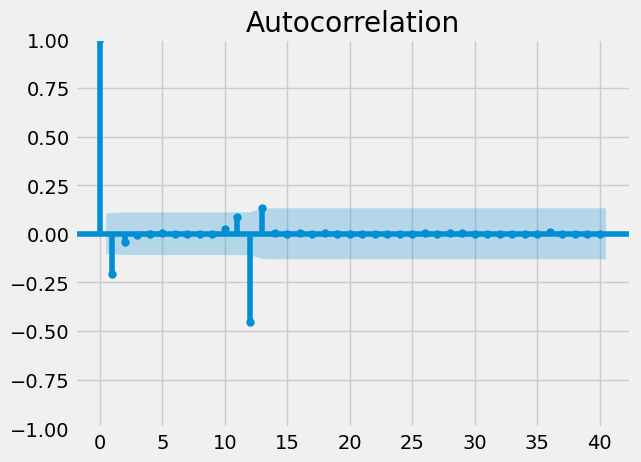

In [416]:
SARIMA_111_011 = SARIMAX(
  train_electricity,
  order=(1, 1, 1),
  seasonal_order=(0, 1, 1, 12), # updated P from 1 to 0
  enforce_stationarity=False,
  enforce_invertibility=False
)

fit_111_011 = SARIMA_111_011.fit()

print(fit_111_011.summary())
plot_acf(fit_111_011.resid.dropna(), lags=40) # plot residual ACF
acorr_ljungbox(fit_111_011.resid.dropna(), lags=[12, 24], return_df=True) # Ljung-Box test

**New iteration helped simplify the model but did not solve seasonal autocorrelation**

SARIMA Results Summary
- All coefficients are now highly significant

Ljung-Box test
- Lag 12 p-value shot even further below 0.05

**Conclusion**
- Seasonal AR term was not the main problem
- Removing it did not destabilise the model AND substantially simplified our model and improved the AIC metric.

→ I will Increase the number of seasonal MA terms.

#### Fit Improved SARIMA (111_013)

                                         SARIMAX Results                                          
Dep. Variable:                        electricity_mwh_log   No. Observations:                  348
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2, 3], 12)   Log Likelihood                 691.226
Date:                                    Mon, 02 Feb 2026   AIC                          -1370.453
Time:                                            18:02:20   BIC                          -1348.290
Sample:                                        01-01-1990   HQIC                         -1361.580
                                             - 12-01-2018                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5153      0.069      7.420      0

,lb_stat,lb_pvalue
12,94.459005,6.726889e-15
24,100.881948,2.124125e-11


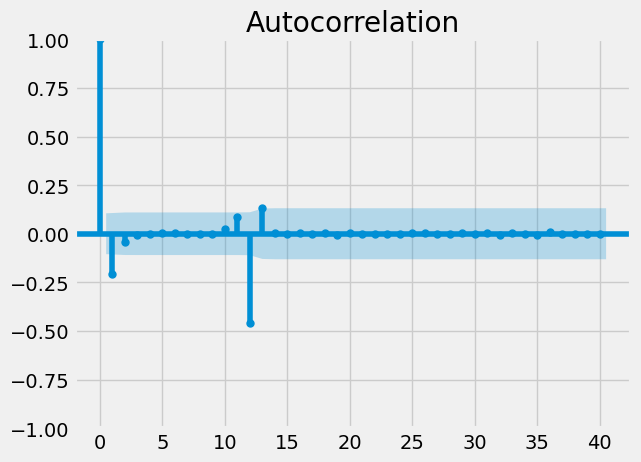

In [417]:
SARIMA_111_013 = SARIMAX(
  train_electricity,
  order=(1, 1, 1),
  seasonal_order=(0, 1, 3, 12), # updated Q from 1 to 5
  enforce_stationarity=False,
  enforce_invertibility=False
)

fit_111_013 = SARIMA_111_013.fit()

print(fit_111_013.summary())
plot_acf(fit_111_013.resid.dropna(), lags=40) # plot residual ACF
acorr_ljungbox(fit_111_013.resid.dropna(), lags=[12, 24], return_df=True) # Ljung-Box test

#### Compare Evaluation Metrics: ***RMSE***, ***MAE***, ***AIC***, ***LB p-value***

In [418]:
# 3 experimented SARIMAs
models_best = {
  'SARIMA_111_111': fit_111_111,
  'SARIMA_111_011': fit_111_011,
  'SARIMA_111_013': fit_111_013
}

# calculate evaluation metrics for other 2 SARIMAs experimented
for model_name, model_fit in models_best.items():
  test_forecast = model_fit.get_forecast(steps=len(test_electricity))
  test_pred = test_forecast.predicted_mean

  test_rmse = np.sqrt(mean_squared_error(test_electricity, test_pred))
  test_mae = mean_absolute_error(test_electricity, test_pred)
  test_mape = np.mean(np.abs((test_electricity - test_pred) / test_electricity)) * 100

  print(f"{model_name}")
  print(f"Test RMSE: {test_rmse:.4f}")
  print(f"Test MAE: {test_mae:.4f}")
  print(f"Test MAPE: {test_mape:.2f}%\n")

SARIMA_111_111
Test RMSE: 0.0375
Test MAE: 0.0298
Test MAPE: 0.43%

SARIMA_111_011
Test RMSE: 0.0364
Test MAE: 0.0288
Test MAPE: 0.41%

SARIMA_111_013
Test RMSE: 0.0337
Test MAE: 0.0260
Test MAPE: 0.37%



**Experimented SARIMA Models (Electricity Consumption)**
| SARIMA Model | Ljung-Box p-value | Test RMSE | Test MAE | AIC |
|--------------|:--------------------------:|:---------:|:--------:|:-----:|
| SARIMA(1,1,1)(1,1,1,12) | 5.27e-15 | 0.0375 | 0.0298 | -1480.81 |
| SARIMA(1,1,1)(0,1,1,12) | 9.65e-08 | 0.0364 | 0.0288 | -1545.83 |
| SARIMA(1,1,1)(0,1,5,12) | 7.49e-15 | 0.0337 | 0.0260 | -1370.45 |

_Note: Ljung-Box p-value reading is at Lag 12._

**Selected Model: SARIMA(1,1,1)(0,1,1,12)**

**Justification:**
- **Lowest AIC** (-1480.81)
- Did not compromise on **Test RMSE** (0.0364) and **MAE** (0.0288)
- All coefficients statistically significant (p < 0.001)
- Lowest Ljung-Box p-value (p = 9.65e-08), though it still failed by a mile...

**Limitation:** Remaining seasonal autocorrelation suggests complex patterns not fully captured by SARIMA. However, this model balances complexity with interpretability and achieves superior out-of-sample performance.

#### Visualise Best SARIMA's Forecast

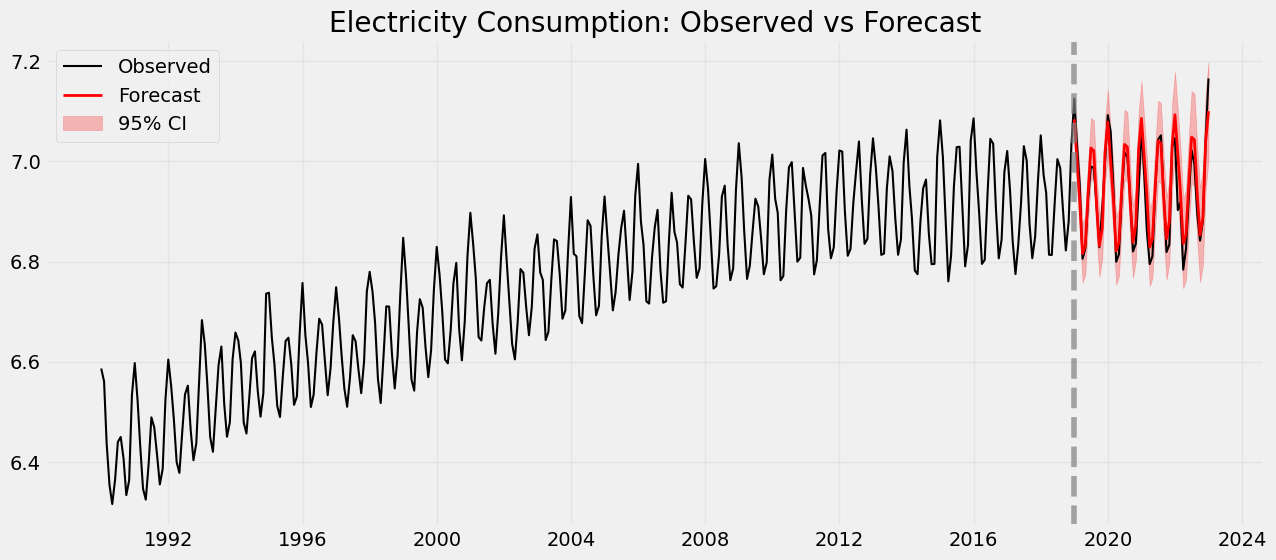

In [419]:
# forecast on test set
test_forecast = fit_111_011.get_forecast(steps=len(test_electricity))
test_pred = test_forecast.predicted_mean
test_ci = test_forecast.conf_int()

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['electricity_mwh_log'], # original series
         label='Observed', color='black', linewidth=1.5)
plt.plot(test_electricity.index, test_pred, # test period/forecast
         label='Forecast', color='red', linewidth=2)

# confidence interval
plt.fill_between(
  test_electricity.index,
  test_ci.iloc[:, 0],
  test_ci.iloc[:, 1],
  color='red', alpha=0.25, label='95% CI'
)

# mark train/test split
plt.axvline(test_electricity.index[0], color='gray', linestyle='--', alpha=0.7)

plt.title('Electricity Consumption: Observed vs Forecast')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

- Results turned out quite well, all of the data points lie within the 95% confidence interval. The forecasted plot also aligns well with the test data.

---

### **Gas Consumption (tons)**

In [420]:
models = {
  'SARIMA_111_111': (1, 1, 1, 1, 1, 1, 12), 
  'SARIMA_111_011': (1, 1, 1, 0, 1, 1, 12), 
  'SARIMA_011_011': (0, 1, 1, 0, 1, 1, 12), 
  'SARIMA_110_110': (1, 1, 0, 1, 1, 0, 12), 
  'SARIMA_211_111': (2, 1, 1, 1, 1, 1, 12) 
}

results = []
fitted_models = {}

for model_name, (p, d, q, P, D, Q, s) in models.items():
  # fit model
  model = SARIMAX(
    train_gas, 
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
  )

  fitted = model.fit(disp=False)
  
  # calculate evaluation metrics
  test_forecast = fitted.get_forecast(steps=len(test_gas))
  test_pred = test_forecast.predicted_mean
  rmse = np.sqrt(mean_squared_error(test_gas, test_pred))
  mae = mean_absolute_error(test_gas, test_pred)
  
  # Ljung-Box test
  lb_test = acorr_ljungbox(fitted.resid.dropna(), lags=[12], return_df=True)
  lb_pval = lb_test.loc[12, 'lb_pvalue']
  
  results.append({
    'Model': model_name,
    'Order': (p, d, q, P, D, Q, s),
    'AIC': fitted.aic,
    'BIC': fitted.bic,
    'Test_RMSE': rmse,
    'Test_MAE': mae,
    'Ljung-Box p-value': lb_pval
  })
  
  fitted_models[model_name] = fitted
      
results_df = pd.DataFrame(results).sort_values('Test_RMSE')
results_df

,Model,Order,AIC,BIC,Test_RMSE,Test_MAE,Ljung-Box p-value
3,SARIMA_110_110,"(1, 1, 0, 1, 1, 0, 12)",1484.455878,1495.779532,1.942631,1.429858,0.000043
0,SARIMA_111_111,"(1, 1, 1, 1, 1, 1, 12)",1337.062754,1355.919960,2.238655,1.863552,0.944880
4,SARIMA_211_111,"(2, 1, 1, 1, 1, 1, 12)",1338.936659,1361.565306,2.252896,1.879954,0.963469
1,SARIMA_111_011,"(1, 1, 1, 0, 1, 1, 12)",1333.835479,1348.921243,2.292974,1.935341,0.168769
2,SARIMA_011_011,"(0, 1, 1, 0, 1, 1, 12)",1356.539560,1367.853883,2.328509,1.982128,0.023074


                                     SARIMAX Results                                      
Dep. Variable:                        gas_tons_bc   No. Observations:                  348
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -739.228
Date:                            Mon, 02 Feb 2026   AIC                           1484.456
Time:                                    18:02:23   BIC                           1495.780
Sample:                                01-01-1990   HQIC                          1488.977
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3042      0.033     -9.183      0.000      -0.369      -0.239
ar.S.L12      -0.5649      0.024   

,lb_stat,lb_pvalue
12,41.359985,4.265548e-05
24,93.601622,3.623994e-10


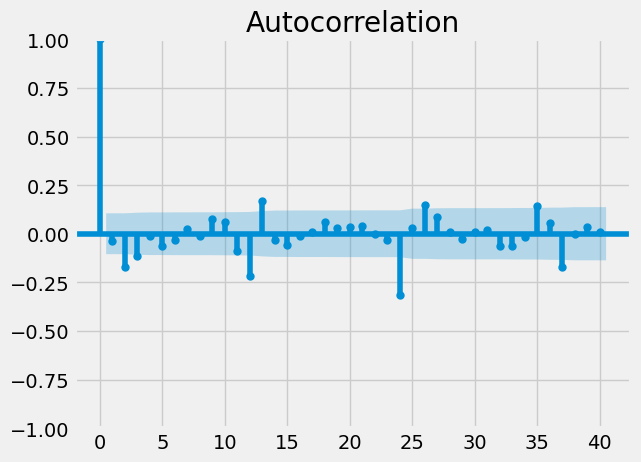

In [421]:
# get best model by RMSE
best_model_name = results_df.iloc[0]['Model']
best_fit = fitted_models[best_model_name]

print(best_fit.summary())
plot_acf(best_fit.resid.dropna(), lags=40) # plot residual ACF
acorr_ljungbox(best_fit.resid.dropna(), lags=[12, 24], return_df=True) # Ljung-Box test

**Experimented SARIMA Models (Gas Consumption)**  
_[results table shown in above output]_

**Selected Model: SARIMA(1,1,0)(1,1,0,12)**

**Justification:**
- **Highest AIC** (1484.46)
- Lowest **Test RMSE** (1.94) and **MAE** (1.43)
- Both AR terms are statistically significant (p < 0.001, |z| for ar.L1: −9.18, ar.S.L12: −23.81)

**Limitation:** Failed Ljung-Box test, achieved a LB p-value of 4.27e-05 (not >0.05).

#### Visualise Best SARIMA's Forecast

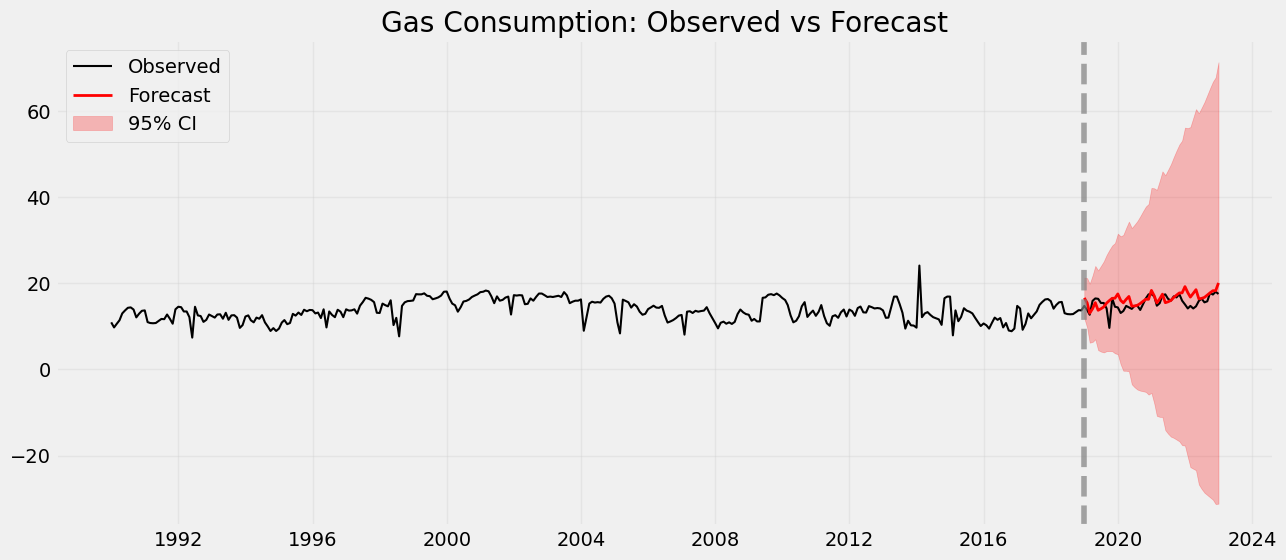

In [422]:
# forecast on test set
test_forecast = best_fit.get_forecast(steps=len(test_gas))
test_pred = test_forecast.predicted_mean
test_ci = test_forecast.conf_int()

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['gas_tons_bc'],
         label='Observed', color='black', linewidth=1.5)
plt.plot(test_gas.index, test_pred,
         label='Forecast', color='red', linewidth=2)

# confidence interval
plt.fill_between(
  test_gas.index,
  test_ci.iloc[:, 0],
  test_ci.iloc[:, 1],
  color='red', alpha=0.25, label='95% CI'
)

# mark train/test split
plt.axvline(test_gas.index[0], color='gray', linestyle='--', alpha=0.7)

plt.title('Gas Consumption: Observed vs Forecast')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#### Water Consumption (tons)

### Hyperparameter Tuning 
ARIMA(p, d, q) - explain how i found best p d q  
GridSearchCV?  
RMSE/MAE?  
Select best model per utility (best for grid and rmse/mae respectively. explore other methods)

### Model Diagnostics
Residual plots
Residual ACF
Ljung–Box test (optional)

Check: Residuals ≈ white noise

#### Residual ACF

#### Ljung-Box Test

#### Visual Evaluation
Plot:
- Actual vs predicted (train, validation, test)
- Forecast with confidence intervals

---

## **STAGE 4: Model Improvement**
Compare ARIMA vs:
1. Naive forecast
2. Simple moving average

3. Upgrade to SARIMA, explain Seasonal (P, D, Q, s)  
  a. Seasonal ARIMA (if seasonality exists)


Model refinement
- Adjust differencing
- Remove unnecessary AR or MA terms

Trade-off between:
1. Complexity
2. Interpretability
3. Overfitting

Final model justification  
Why chosen model performs best  
Why others underperform

### 